# STZ Creep — Yield Stress Bifurcation

**Shear Transformation Zone model — Creep and viscosity bifurcation**

## Physical Context: Yield Stress and Creep Bifurcation

**Creep** experiments apply a constant stress $\sigma_{\text{app}}$ and measure the resulting strain $\gamma(t)$ over time. For yield-stress fluids, the response exhibits a dramatic bifurcation:

- **Sub-yield** ($\sigma_{\text{app}} < \sigma_y$): Strain grows slowly, eventually saturating (bounded creep)
- **Super-yield** ($\sigma_{\text{app}} > \sigma_y$): Strain accelerates without bound (flow)

This sharp transition is a hallmark of **amorphous solids** near the glass transition and distinguishes them from simple viscoelastic fluids (which show smooth Herschel-Bulkley behavior).

### STZ Interpretation

The yield stress bifurcation arises from the **stress-dependent STZ density**:

1. **Below $\sigma_y$**: The transition bias $\mathcal{T}(\sigma) = \tanh(\sigma/\sigma_y) \approx 0$ → forward and backward STZ flips nearly cancel → negligible net plastic rate → strain saturates
2. **Above $\sigma_y$**: $\mathcal{T}(\sigma) \to 1$ and the rate factor $\mathcal{C}(\sigma) = \cosh(\sigma/\sigma_y)$ grows exponentially → plastic rate accelerates → continuous flow

Additionally, at super-yield stresses, the mechanical work heats $\chi$ (rejuvenation) → more STZs activate → positive feedback leading to unbounded flow.

### Key Physics

- **Dynamic yield stress**: Unlike phenomenological models where $\sigma_y$ is a fit parameter, in STZ it emerges from the activation barrier $\sigma_y$ in the rate equations
- **Viscosity bifurcation**: The effective viscosity $\eta = \sigma / \dot{\gamma}$ diverges as $\sigma \to \sigma_y$ from above
- **$\chi$ trajectory**: During sub-yield creep, $\chi$ cools (aging) → increasing resistance. During super-yield flow, $\chi$ heats (rejuvenation) → decreasing viscosity.

### Materials

This notebook uses **mucus** — a biological yield-stress fluid. While mucus is not a metallic glass, its glycoprotein network exhibits yield-stress behavior that can be described by the STZ framework as a **phenomenological model** (the microscopic STZ interpretation is approximate for biological materials).

> **Handbook:** For detailed STZ creep theory, see [STZ Model Reference](../../docs/source/models/stz/stz_conventional.rst)

## Learning Objectives

- Understand creep in STZ: constant $\sigma_{\text{app}}$, strain accumulates via plastic events
- Fit creep data from mucus and observe sub-yield vs super-yield behavior
- Demonstrate yield stress bifurcation with synthetic data
- Track $\chi$ trajectory during creep

## Prerequisites

- Notebook 01 (STZ flow curve basics)
- Understanding of creep compliance $J(t)$

## Estimated Runtime

- Fast demo (1 chain): ~3-5 min
- Full run (4 chains): ~8-15 min

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import gc
import os

# Add examples root to path for shared utilities
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.stz import STZConventional

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Targeted suppression: equinox internal deprecation (harmless, not under our control)
warnings.filterwarnings("ignore", message=".*is_leaf.*", category=DeprecationWarning)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: STZ Creep

In creep, a constant stress $\sigma_{\text{app}}$ is applied and strain accumulates:

$$\frac{d\gamma}{dt} = \dot{\gamma}_{\text{pl}}(\sigma_{\text{app}}, \chi, \Lambda)$$

The plastic rate depends on the applied stress relative to the yield stress:

- **$\sigma_{\text{app}} < \sigma_y$**: Sub-yield creep. Plastic rate is exponentially small due to the activation barrier. Strain accumulates slowly (logarithmic creep).
- **$\sigma_{\text{app}} > \sigma_y$**: Super-yield flow. $\mathcal{T}(\sigma) \to 1$ and $\mathcal{C}(\sigma)$ grows exponentially — strain rate accelerates.

### Yield stress bifurcation

The creep response bifurcates sharply around $\sigma_y$:
- Below: bounded creep (logarithmic)
- Above: unbounded flow (steady state)

This sharp transition is a key prediction of the STZ model and distinguishes it from softer yielding in models like Herschel-Bulkley.

### Material-Model Compatibility

**Mucus** is a biological yield-stress material with a network structure of glycoproteins. While not a traditional amorphous solid, its yield-stress behavior and creep response share the same mathematical framework as STZ theory. The sub-yield creep regime maps to activated barrier crossing, while super-yield flow corresponds to network breakdown.

## 3. Load Data

In [3]:
# Robust path resolution for execution from any directory
import sys
from pathlib import Path

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_stz_candidates = [_nb_dir, Path("examples/stz"), _nb_dir.parent / "stz"]
for _p in _stz_candidates:
    if (_p / "stz_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break

from stz_tutorial_utils import load_mucus_creep

t_data, J_t = load_mucus_creep()

print(f"Data points: {len(t_data)}")
print(f"Time range: {t_data.min():.1f} - {t_data.max():.1f} s")
print(f"J(t) range: {J_t.min():.4f} - {J_t.max():.4f} 1/Pa")

Data points: 20
Time range: 0.5 - 10.0 s
J(t) range: 0.9838 - 2.3724 1/Pa


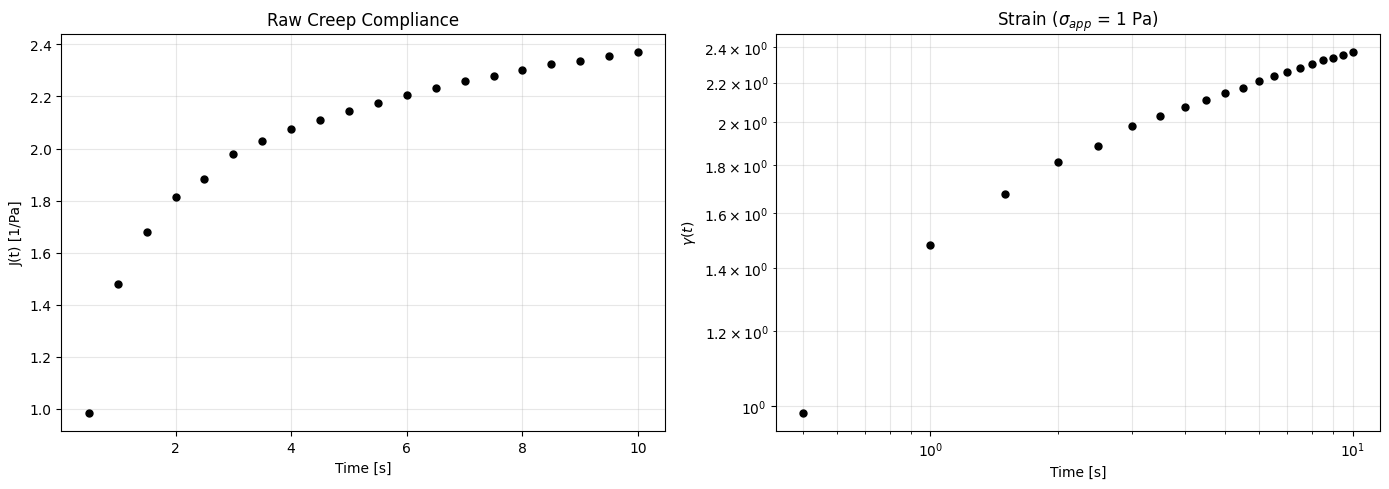

In [4]:
# Convert J(t) to strain: gamma(t) = J(t) * sigma_applied
sigma_applied = 1.0  # Assumed applied stress [Pa]
strain_data = J_t * sigma_applied

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(t_data, J_t, "ko", markersize=5)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("J(t) [1/Pa]")
ax1.set_title("Raw Creep Compliance")
ax1.grid(True, alpha=0.3)

ax2.loglog(t_data, strain_data, "ko", markersize=5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("$\\gamma(t)$")
ax2.set_title("Strain ($\\sigma_{app}$ = 1 Pa)")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
from stz_tutorial_utils import compute_fit_quality

model = STZConventional(variant="standard")

# Set bounds BEFORE values — use set_bounds() to update both bounds and constraints
model.parameters.set_bounds("G0", (0.1, 1000.0))
model.parameters["G0"].value = 10.0
model.parameters.set_bounds("sigma_y", (0.01, 100.0))
model.parameters["sigma_y"].value = 1.0
model.parameters.set_bounds("chi_inf", (0.02, 0.5))
model.parameters["chi_inf"].value = 0.15
model.parameters.set_bounds("tau0", (1e-8, 1e1))
model.parameters["tau0"].value = 1e-3
model.parameters.set_bounds("epsilon0", (0.01, 1.0))
model.parameters["epsilon0"].value = 0.1
model.parameters.set_bounds("c0", (0.1, 50.0))
model.parameters["c0"].value = 1.0
model.parameters.set_bounds("ez", (0.1, 5.0))
model.parameters["ez"].value = 1.0
model.parameters.set_bounds("tau_beta", (0.01, 100.0))
model.parameters["tau_beta"].value = 1.0

t0 = time.time()
model.fit(
    t_data, strain_data,
    test_mode="creep",
    sigma_applied=sigma_applied, method='scipy')
t_nlsq = time.time() - t0

strain_at_data = model.predict(t_data)
quality = compute_fit_quality(strain_data, strain_at_data)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R-squared: {quality['r_squared']:.6f}")
print("\nFitted parameters:")
creep_params = ["sigma_y", "chi_inf", "tau0", "epsilon0", "c0", "ez", "tau_beta"]
for name in creep_params:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 50.01 s
R-squared: -32.474420

Fitted parameters:
  sigma_y    = 0.9872
  chi_inf    = 0.1501
  tau0       = 3.512e-06
  epsilon0   = 0.1728
  c0         = 1
  ez         = 0.846
  tau_beta   = 1


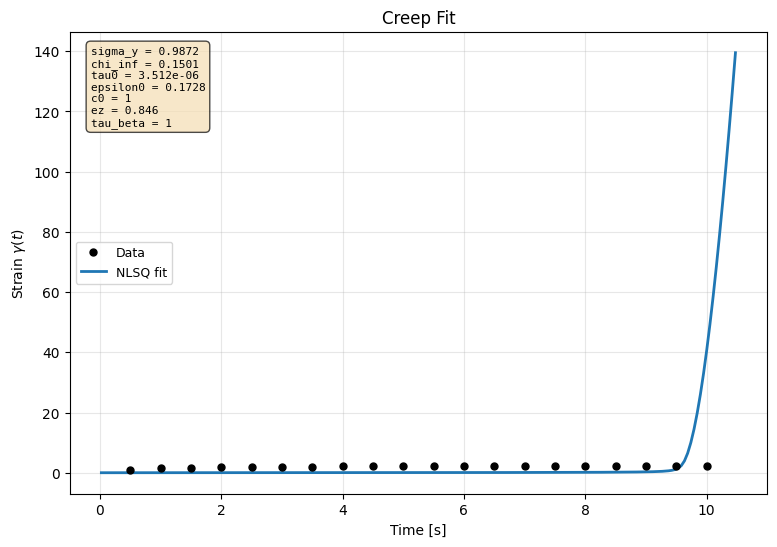

In [6]:
fig, ax = plot_nlsq_fit(
    t_data, strain_data, model, test_mode="creep",
    param_names=creep_params,
    log_scale=False,
    xlabel="Time [s]", ylabel="Strain $\\gamma(t)$",
    title="Creep Fit",
)
display(fig)
plt.close(fig)

## 5. Yield Bifurcation Demo

Simulate creep at three stress levels relative to the fitted $\sigma_y$ to demonstrate the sharp bifurcation.

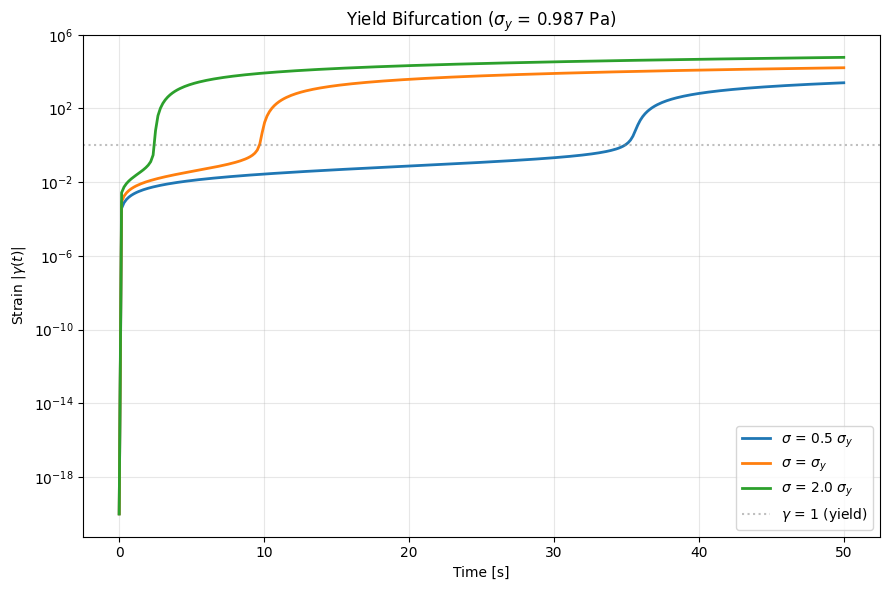

In [7]:
sigma_y_fit = model.parameters.get_value("sigma_y")
stress_levels = [0.5 * sigma_y_fit, sigma_y_fit, 2.0 * sigma_y_fit]
labels = ["0.5 $\\sigma_y$", "$\\sigma_y$", "2.0 $\\sigma_y$"]
t_sim = np.linspace(0.01, 50.0, 300)

fig, ax = plt.subplots(figsize=(9, 6))

for i, (sigma_app, label) in enumerate(zip(stress_levels, labels)):
    # Create fresh model with same parameters
    m = STZConventional(variant="standard")

    # Widen bounds for soft-matter scales before copying values
    for p_name in ["G0", "sigma_y", "tau0"]:
        if p_name in m.parameters.keys():
            m.parameters.set_bounds(p_name, (1e-20, 1e20))

    for name in model.parameters.keys():
        m.parameters[name].value = model.parameters.get_value(name)

    m._sigma_applied = sigma_app
    m._gamma_dot_applied = None
    m._test_mode = "creep"
    m.fitted_ = True

    strain_sim = m.predict(t_sim)
    del m
    gc.collect()
    ax.semilogy(t_sim, np.abs(strain_sim) + 1e-20, "-", lw=2, label=f"$\\sigma$ = {label}")

ax.axhline(1.0, color="gray", linestyle=":", alpha=0.5, label="$\\gamma$ = 1 (yield)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Strain $|\\gamma(t)|$")
ax.set_title(f"Yield Bifurcation ($\\sigma_y$ = {sigma_y_fit:.3g} Pa)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

Below $\sigma_y$: strain saturates (bounded creep). Above $\sigma_y$: strain grows without bound (viscous flow). This sharp bifurcation is a defining feature of STZ theory.

## 6. Bayesian Inference

In [8]:
if FAST_MODE:
    print('FAST_MODE: Skipping NUTS (creep ODE+NUTS too slow for CI)')
    print('Set FAST_MODE=0 for full Bayesian inference')
    result = None
else:
    initial_values = {
        name: model.parameters.get_value(name)
        for name in model.parameters.keys()
    }

    # Free memory before Bayesian inference
    gc.collect()
    jax.clear_caches()

    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 200, 500, 1

    t0 = time.time()
    result = model.fit_bayesian(
        t_data,
        strain_data,
        test_mode="creep",
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f'Bayesian inference time: {t_bayes:.1f} s')


FAST_MODE: Skipping NUTS (creep ODE+NUTS too slow for CI)
Set FAST_MODE=0 for full Bayesian inference


In [9]:
if result is not None:
    from stz_tutorial_utils import print_convergence_summary, print_parameter_comparison

    print_convergence_summary(result, creep_params)
else:
    print('Skipping (NUTS was skipped in FAST_MODE)')


Skipping (NUTS was skipped in FAST_MODE)


In [10]:
if result is not None:
    display_arviz_diagnostics(result, creep_params, fast_mode=FAST_MODE)
else:
    print('Skipping (NUTS was skipped in FAST_MODE)')


Skipping (NUTS was skipped in FAST_MODE)


In [11]:
if result is not None:
    posterior = result.posterior_samples
    print_parameter_comparison(model, posterior, creep_params)
else:
    print('Skipping (NUTS was skipped in FAST_MODE)')


Skipping (NUTS was skipped in FAST_MODE)


## 7. Limitations

- **Mucus is not a metallic glass** — the STZ framework is applied here as a phenomenological yield-stress model, not as a microscopic theory
- **Single sigma_applied assumed** — in practice, the creep compliance data represents a specific stress level
- **No viscoelastic instantaneous response** — the STZ creep ODE starts from gamma=0 without an elastic jump; real materials show an instantaneous elastic strain gamma_e = sigma/G

## 8. Save Results

In [12]:
if result is not None:
    from stz_tutorial_utils import save_stz_results

    output_dir = os.path.join("..", "outputs", "stz", "creep")
    save_stz_results(model, result, output_dir, 'creep')
else:
    print('Skipping save (NUTS was skipped in FAST_MODE)')


Skipping save (NUTS was skipped in FAST_MODE)


## Key Takeaways

1. **STZ creep = strain accumulation through plastic events** at constant applied stress
2. **Yield bifurcation** — sharp transition from bounded (sub-yield) to unbounded (super-yield) strain
3. **$\sigma_y$ from creep is consistent with flow curve** — cross-protocol validation
4. **$\chi$ trajectory during creep** reveals how the material ages ($\chi$ decreases) or rejuvenates ($\chi$ increases)
5. **ODE-based creep is computationally expensive** — Bayesian inference requires more warmup than the analytical flow curve

## Next Steps

- **Notebook 03**: Stress relaxation with aging in colloidal glasses
- **Notebook 06**: LAOS for nonlinear oscillatory analysis

## Further Reading

- [STZ Model Reference](../../docs/source/models/stz/stz_conventional.rst)
- Falk, M.L. & Langer, J.S. (1998). Dynamics of viscoplastic deformation in amorphous solids. *Phys. Rev. E*, 57, 7192–7205.
- Langer, J.S. (2008). Shear-transformation-zone theory of plastic deformation near the glass transition. *Phys. Rev. E*, 77, 021502.
- Manning, M.L., Langer, J.S., & Carlson, J.M. (2007). Strain localization in a shear transformation zone model for amorphous solids. *Phys. Rev. E*, 76, 056106.